## Load Data and Initial Grid Search

In [23]:
DATA_NAME = 'approx1e5-pastis-wavelet-gray' # size-name-transform-channel

In [24]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\pastis\\wavelet\\approx1e5\\gray'

In [25]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [26]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

In [27]:
def create_kurt_var_ksstat_df(cdf_dict):
    cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(cdf_dict.items())})
    cdfs_df['r'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[0])
    cdfs_df['eta'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[1])
    cdfs_df['cdf'] = pd.Series(cdfs_df["(r,eta),cdf"].str[1])
    cdfs_df['variance'] = np.nan_to_num(cdfs_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
    cdfs_df['kurtosis'] = cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
    return cdfs_df

In [28]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:817: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:822: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:822: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:822: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

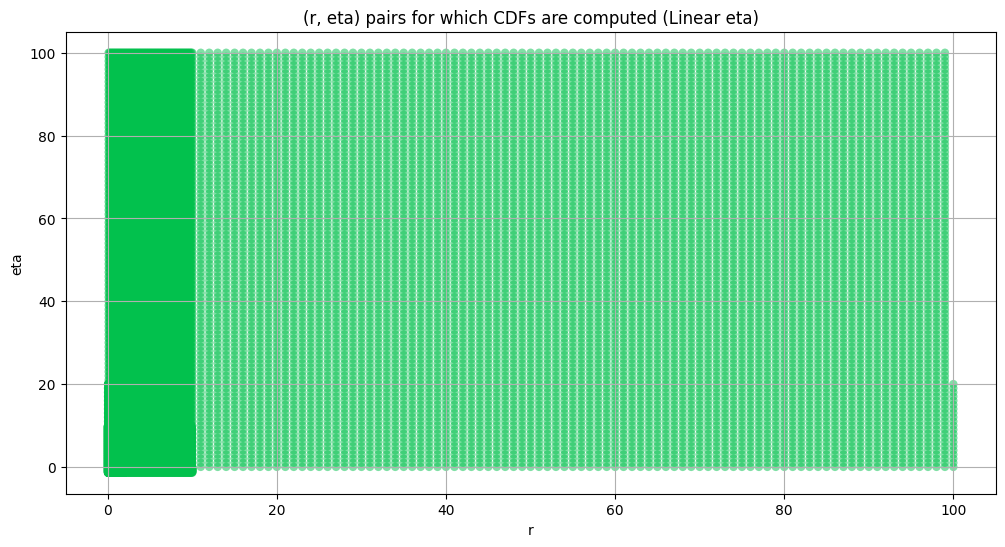

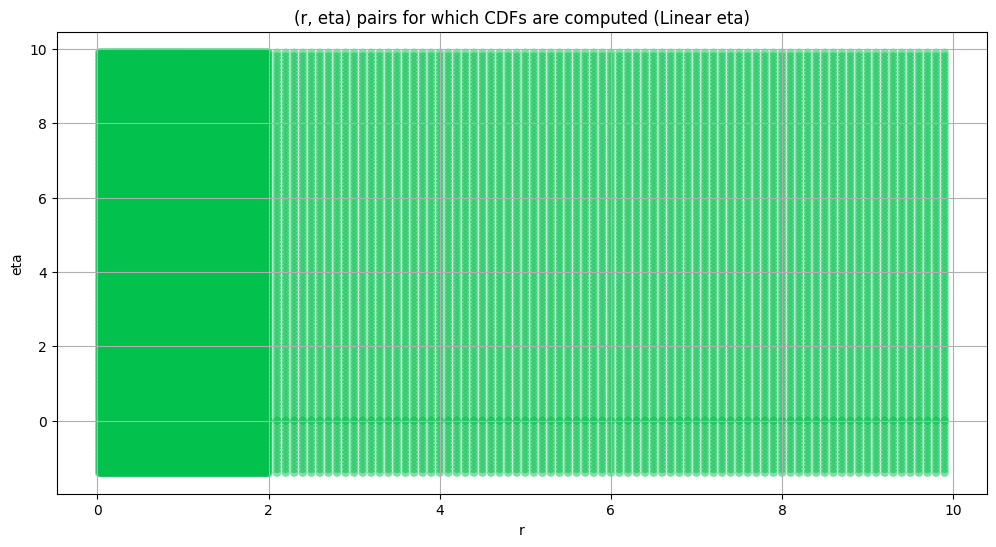

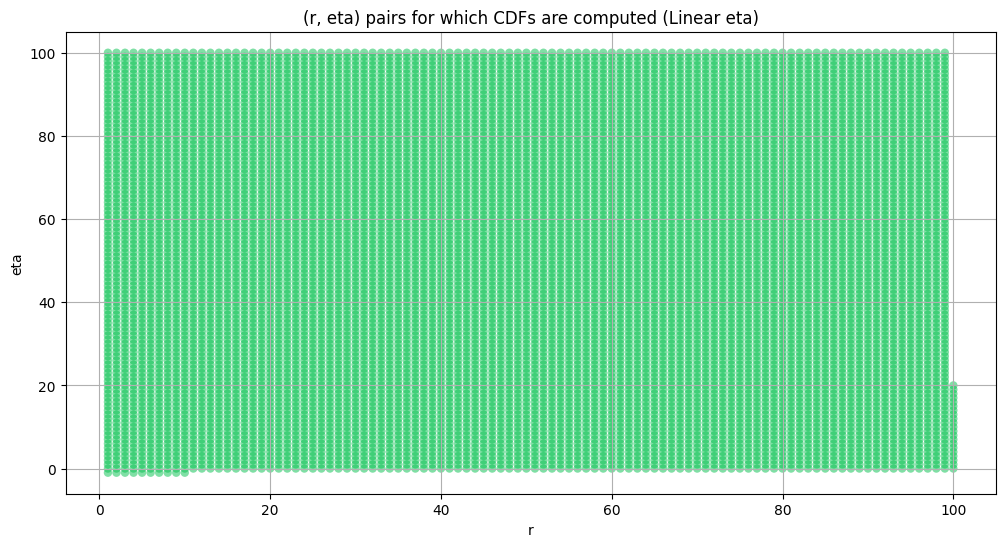

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


r           eta       variance      kurtosis
count  51883.000000  51883.000000   5.188300e+04  5.064200e+04
mean      11.990701     21.476312            inf           inf
std       22.639851     28.237512            inf           NaN
min        0.020000     -1.400000   0.000000e+00  4.787254e-04
25%        1.000000      3.000000   9.882555e-01  1.513901e-02
50%        1.970000      7.600000   1.482803e+00  1.950077e-01
75%        8.100000     32.000000   5.742021e+00  6.565170e-01
max      100.000000    100.000000  1.797693e+308           inf

In [29]:
create_scatter_plot(all_cdfs_df)
create_scatter_plot(all_cdfs_df[(all_cdfs_df['r'] < 10) & (all_cdfs_df['eta'] < 10)])
create_scatter_plot(coarse_cdf_df)

all_cdfs_df.describe()

In [30]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [31]:
''' Only need to run commented code once'''    
# for group in  GROUPS:
#     print(f'{GROUP.capitalize()} {group}')
#     obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
#                                                                              n_bootstrap=n_bootstrap, 
#                                                                              bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
#                                                                              metric= np.var, 
#                                                                              ci=ci)
#     obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
#                                                                                  n_bootstrap=n_bootstrap, 
#                                                                                  bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
#                                                                                  metric= stats.kurtosis, ci=ci)  
#     master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
#     master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
#     master_df.loc[group, 'total_samples'] = group_total_samples[group]

# master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
var_kurt_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
master_df

obs_var   var_lower   var_upper    obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      803.473892  751.378924  857.028528    0.094996   -0.097312    0.299754   
3      275.270192  264.590167  286.288690    0.374403    0.219221    0.546058   
4       80.847728   77.046186   84.706154    1.357251    1.030759    1.855357   
5       19.882305   18.762781   21.056150    3.074957    2.230657    5.079245   
6        4.187365    3.884993    4.587161    7.592764    3.861297   29.028659   
7        0.819285    0.747353    0.916054   13.123555    6.050411   48.182214   
8        0.136744    0.117431    0.211746  172.661568    8.088640  756.942474   

       total_samples  
layer                 
2             3180.0  
3            12720.0  
4            50880.0  
5           203520.0  
6           814080.0  
7          3256320.0  
8         13025280.0

In [32]:
def add_tests_to_df(cdfs_df, group, var_kurt_df, ksstats):
    cdfs_df['pass_var'] = (cdfs_df['variance'] > var_kurt_df.loc[group, 'var_lower']) & (cdfs_df['variance'] < var_kurt_df.loc[group, 'var_upper'])
    cdfs_df['pass_kurt'] = (cdfs_df['kurtosis'] > var_kurt_df.loc[group, 'kurt_lower']) & (cdfs_df['kurtosis'] < var_kurt_df.loc[group,'kurt_upper'])
    cdfs_df['ksstat'] = ksstats
    cutoff = stats.kstwo(n=var_kurt_df.loc[group, 'total_samples']).isf(0.05)
    cdfs_df['pass_kstest'] = cdfs_df['ksstat'].apply(lambda x: True if x < cutoff else False)
    return cdfs_df

####
Layer  2


100%|██████████| 51883/51883 [04:00<00:00, 215.87it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 3180, Without approximation : 3180.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


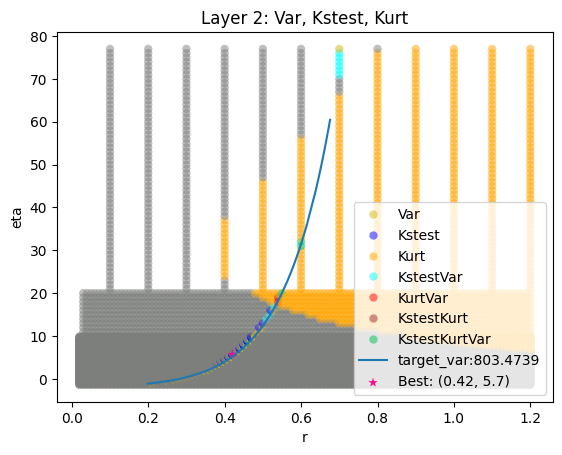

####
Layer  3


100%|██████████| 51883/51883 [13:41<00:00, 63.12it/s]    


Finding Minimum after computing 51883 CDFs
Number of samples: 12720, Without approximation : 12720.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


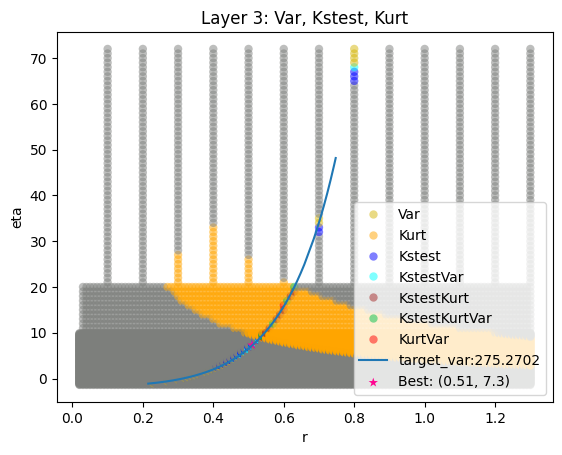

####
Layer  4


100%|██████████| 51883/51883 [12:45<00:00, 67.76it/s] 


Finding Minimum after computing 51883 CDFs
Number of samples: 50880, Without approximation : 50880.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


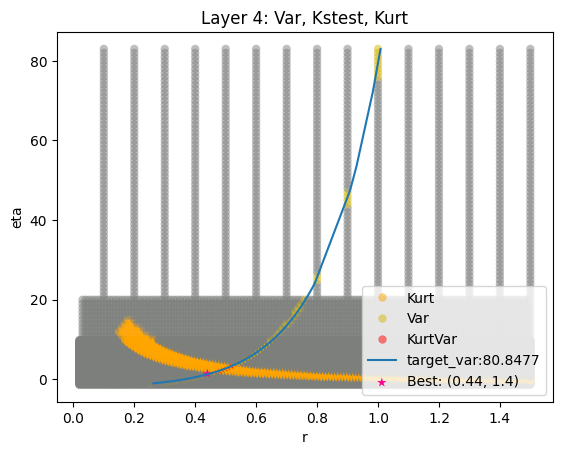

####
Layer  5


100%|██████████| 51883/51883 [16:53<00:00, 51.19it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 203520.0


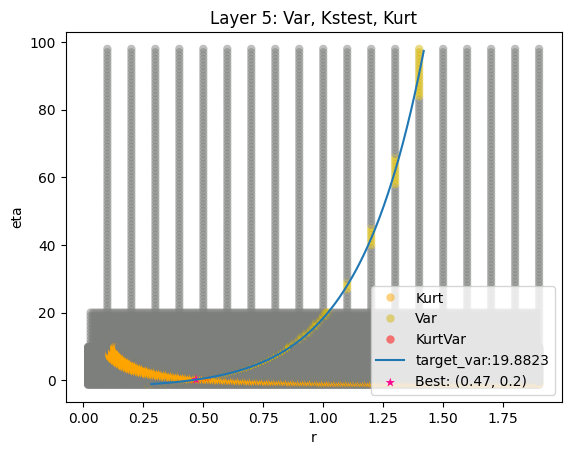

####
Layer  6


100%|██████████| 51883/51883 [16:57<00:00, 51.01it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 814080.0


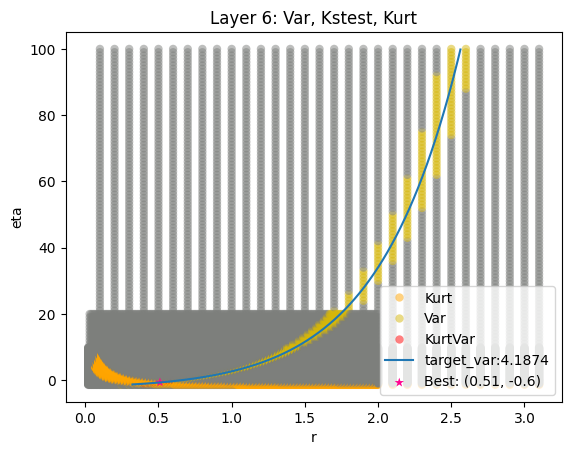

####
Layer  7


100%|██████████| 51883/51883 [16:57<00:00, 50.97it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 3256320.0


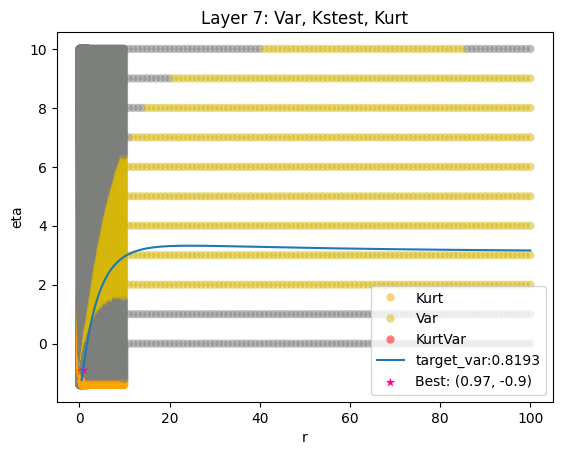

####
Layer  8


100%|██████████| 51883/51883 [17:15<00:00, 50.10it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 13025280.0


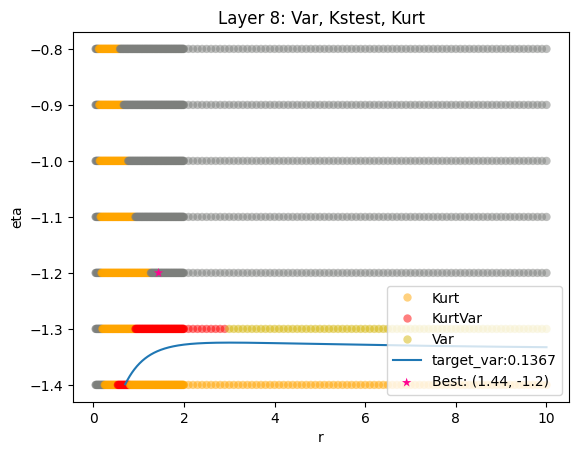

obs_var   var_lower   var_upper    obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      803.473892  751.378924  857.028528    0.094996   -0.097312    0.299754   
3      275.270192  264.590167  286.288690    0.374403    0.219221    0.546058   
4       80.847728   77.046186   84.706154    1.357251    1.030759    1.855357   
5       19.882305   18.762781   21.056150    3.074957    2.230657    5.079245   
6        4.187365    3.884993    4.587161    7.592764    3.861297   29.028659   
7        0.819285    0.747353    0.916054   13.123555    6.050411   48.182214   
8        0.136744    0.117431    0.211746  172.661568    8.088640  756.942474   

       total_samples  initial_r  initial_eta  kstest_stat_initial  \
layer                                                               
2             3180.0       0.42          5.7             0.018069   
3            12720.0       0.51          7.3             0.004615   
4            50880.0       0.44          1.4             0.006270   
5           203520.0       0.47          0.2             0.005236   
6           814080.0       0.51         -0.6             0.004349   
7          3256320.0       0.97         -0.9             0.010413   
8         13025280.0       1.44         -1.2             0.051520   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.024030  
3                     0.012029  
4                     0.006018  
5                     0.003010  
6                     0.001505  
7                     0.000753  
8                     0.000376

In [33]:
''' Only need to run commented code once'''
sorted_params = sorted(all_cdfs)
group_cdf_df_dict = dict()

for i, group in enumerate(GROUPS):
    print(f"####\n{GROUP.capitalize()} ", group)
    sample = group_data_map[group]
    group_cdf_df = all_cdfs_df.copy()
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
    master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
    print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
    master_df.loc[group, 'kstest_stat_initial'] = min_stat
    cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

    group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
    
    group_cdf_df_dict[group] = group_cdf_df
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']

    fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                          plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                          target_var = master_df.loc[group, 'obs_var'],
                          best_param = initial_param)
    
    fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

    # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
    # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
    # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

    # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_var)
    # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_kurt)

master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
pd.to_pickle(group_cdf_df_dict, os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))

group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"), index_col=GROUP)
master_df

In [34]:
''' Only need to run commented code once'''
best_params_eta0 = []
for i, group in enumerate(GROUPS):
    if master_df.loc[group, 'initial_eta'] != 0:
        sample = group_data_map[group]
        group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
        cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
        ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
        best_params_eta0.append(best_param_eta0[0])
        master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
    else:
        master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
        best_params_eta0.append(master_df.loc[group, 'initial_r'])
master_df['best_r_eta0'] = best_params_eta0
master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"), index_col=GROUP)
master_df

100%|██████████| 369/369 [00:03<00:00, 105.86it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 125.23it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:06<00:00, 54.29it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:10<00:00, 33.61it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:10<00:00, 34.15it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:11<00:00, 31.60it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:12<00:00, 30.16it/s]


Finding Minimum after computing 369 CDFs


obs_var   var_lower   var_upper    obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      803.473892  751.378924  857.028528    0.094996   -0.097312    0.299754   
3      275.270192  264.590167  286.288690    0.374403    0.219221    0.546058   
4       80.847728   77.046186   84.706154    1.357251    1.030759    1.855357   
5       19.882305   18.762781   21.056150    3.074957    2.230657    5.079245   
6        4.187365    3.884993    4.587161    7.592764    3.861297   29.028659   
7        0.819285    0.747353    0.916054   13.123555    6.050411   48.182214   
8        0.136744    0.117431    0.211746  172.661568    8.088640  756.942474   

       total_samples  initial_r  initial_eta  kstest_stat_initial  \
layer                                                               
2             3180.0       0.42          5.7             0.018069   
3            12720.0       0.51          7.3             0.004615   
4            50880.0       0.44          1.4             0.006270   
5           203520.0       0.47          0.2             0.005236   
6           814080.0       0.51         -0.6             0.004349   
7          3256320.0       0.97         -0.9             0.010413   
8         13025280.0       1.44         -1.2             0.051520   

       kstest_stat_cutoff_0.05  kstest_stat_eta0  best_r_eta0  
layer                                                          
2                     0.024030          0.060346         0.26  
3                     0.012029          0.037012         0.29  
4                     0.006018          0.023319         0.34  
5                     0.003010          0.005653         0.44  
6                     0.001505          0.020507         0.74  
7                     0.000753          0.082284         6.10  
8                     0.000376          0.227351         6.00

In [35]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2


100%|██████████| 834/834 [00:03<00:00, 245.42it/s]


Finding Minimum after computing 834 CDFs
Iter 1 layer 2 best parameters: ((0.42, 5.679), 0.017519866326516365)
(0.4205, 5.669), 850 of 1254


100%|██████████| 855/855 [00:02<00:00, 395.52it/s]


Finding Minimum after computing 855 CDFs
Iter 2 layer 2 best parameters: ((0.42, 5.679), 0.017519866326516365)


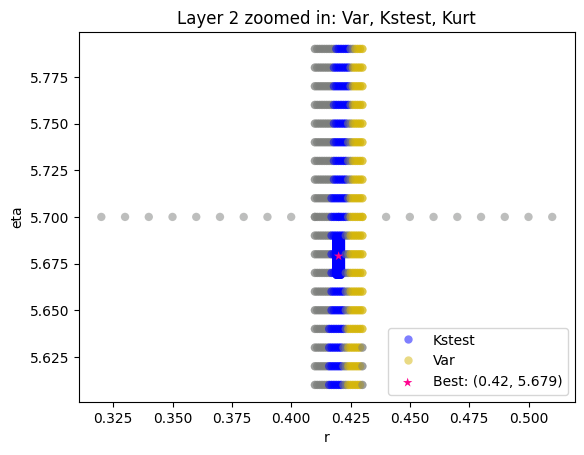

Layer 3


100%|██████████| 834/834 [00:04<00:00, 186.09it/s]


Finding Minimum after computing 834 CDFs
Iter 1 layer 3 best parameters: ((0.5089, 7.211), 0.004221089215717844)
(0.5079, 7.216), 850 of 1254
(0.5085, 7.201), 900 of 1254
(0.509, 7.206), 950 of 1254
(0.5096, 7.202), 1000 of 1254


100%|██████████| 1034/1034 [00:04<00:00, 231.92it/s]


Finding Minimum after computing 1034 CDFs
Iter 2 layer 3 best parameters: ((0.5088, 7.205), 0.004211309584760903)


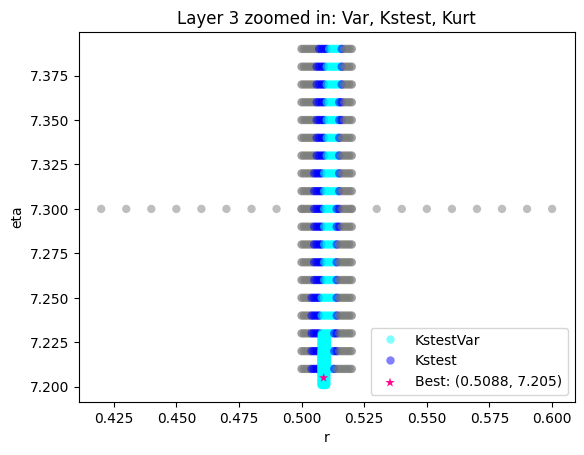

Layer 4


100%|██████████| 873/873 [00:08<00:00, 108.81it/s]


Finding Minimum after computing 873 CDFs
Iter 1 layer 4 best parameters: ((0.4354, 1.3), 0.005286301716882269)
(0.4345, 1.295), 900 of 1314
(0.4347, 1.303), 950 of 1314
(0.435, 1.29), 1000 of 1314
(0.4355, 1.29), 1050 of 1314
(0.436, 1.29), 1100 of 1314


100%|██████████| 1149/1149 [00:15<00:00, 74.94it/s]


Finding Minimum after computing 1149 CDFs
Iter 2 layer 4 best parameters: ((0.4353, 1.298), 0.005274668143765093)


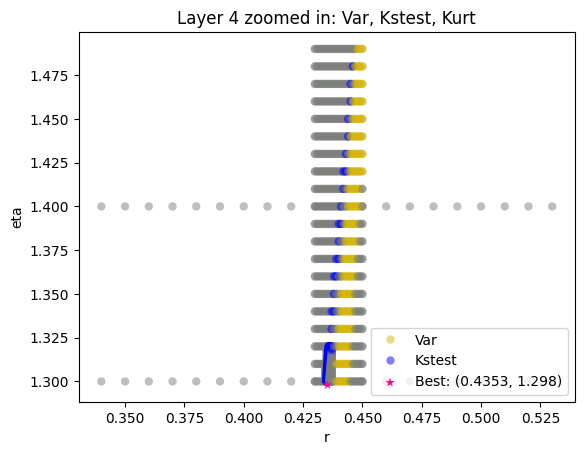

Layer 5


100%|██████████| 938/938 [00:20<00:00, 45.71it/s]


Finding Minimum after computing 938 CDFs
Iter 1 layer 5 best parameters: ((0.4591, 0.10991), 0.003592408525127433)
(0.4581, 0.11091), 950 of 1358
(0.4584, 0.10091), 1000 of 1358
(0.4586, 0.11091), 1050 of 1358
(0.4589, 0.10091), 1100 of 1358
(0.4591, 0.11191), 1150 of 1358
(0.4594, 0.10191), 1200 of 1358
(0.4596, 0.11191), 1250 of 1358
(0.4599, 0.10191), 1300 of 1358
(0.4601, 0.11191), 1350 of 1358


100%|██████████| 1357/1357 [00:28<00:00, 47.55it/s]


Finding Minimum after computing 1357 CDFs
Iter 2 layer 5 best parameters: ((0.4581, 0.10291), 0.0035210080264698185)
(0.45809, 0.10281), 1400 of 1798
(0.45809, 0.10289), 1450 of 1798
(0.4581, 0.10298), 1500 of 1798
(0.4581, 0.10287), 1550 of 1798
(0.4581, 0.10298), 1600 of 1798
(0.4581, 0.10287), 1650 of 1798
(0.45811, 0.10297), 1700 of 1798
(0.45811, 0.10284), 1750 of 1798


100%|██████████| 1419/1419 [00:30<00:00, 46.19it/s]


Finding Minimum after computing 1419 CDFs
Iter 3 layer 5 best parameters: ((0.45811, 0.10285), 0.003516250435201429)


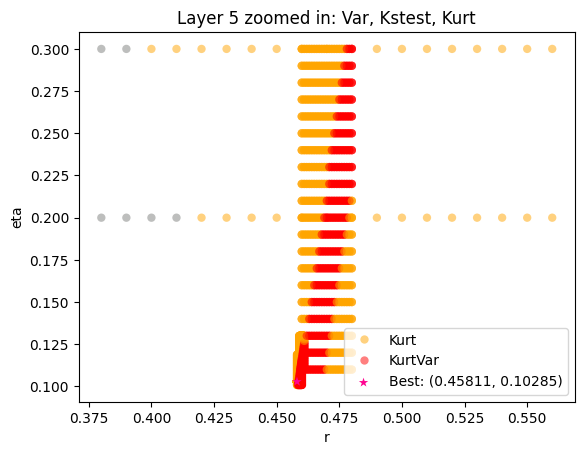

Layer 6


100%|██████████| 911/911 [00:19<00:00, 45.74it/s]


Finding Minimum after computing 911 CDFs
Iter 1 layer 6 best parameters: ((0.51779, -0.57791), 0.003537784678162348)
(0.51689, -0.57091), 950 of 1352
(0.51719, -0.58391), 1000 of 1352
(0.51739, -0.57591), 1050 of 1352
(0.51759, -0.56791), 1100 of 1352
(0.51789, -0.57991), 1150 of 1352
(0.51809, -0.57191), 1200 of 1352
(0.51839, -0.58491), 1250 of 1352
(0.51859, -0.57691), 1300 of 1352
(0.51879, -0.56891), 1350 of 1352


100%|██████████| 1351/1351 [00:40<00:00, 33.11it/s]


Finding Minimum after computing 1351 CDFs
Iter 2 layer 6 best parameters: ((0.51839, -0.57691), 0.003525409028244997)


In [ ]:
SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [2, 2, 2, 3, 3, 3, 3, 3]))
NUM_SAMPLES_OPTIMIZE = 2000

if SKIP_OPTIMIZE_STEP:
    master_df['kstest_stat'] = master_df['kstest_stat_initial']
    master_df[f'best_r'] = master_df['initial_r']
    master_df[f'best_eta'] = master_df['initial_eta']
else:
    for group in GROUPS: 
        print(f"{GROUP.capitalize()} {group}")
        sample = group_data_map[group]
        initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
        r_granularity = 10
        eta_granularity = 10
        for i in range(-1, -5, -1):
            if tuple([round_to_sigfigs(initial_r + 10.**i), initial_eta]) in all_cdfs:
                r_granularity = 10.**i
            if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i)]) in all_cdfs:
                
                eta_granularity = 10.**i

        for d in range(1, NUM_ITERS[group] + 1):
            if d == 1:
                initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            else:
                initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
            r_granularity = r_granularity * 10.0**(-d+1) 
            eta_granularity = eta_granularity * 10.0**(-d+1) 

            r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
            eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
            simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
            cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
            ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

            temp_df = create_kurt_var_ksstat_df(cdfs_dict)
            temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
            group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
            master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
            master_df.loc[group, 'kstest_stat_best'] = kstest_stat
            master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
            master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
            
            print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

        temp_df = group_cdf_df_dict[group]
        eps = 0.1
        filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                        (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                        (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                        (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']
        fig = combo_test_plot(filtered_df, cols, 
                              plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                              best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
        fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
        
master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', f'best_r', f'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'), index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

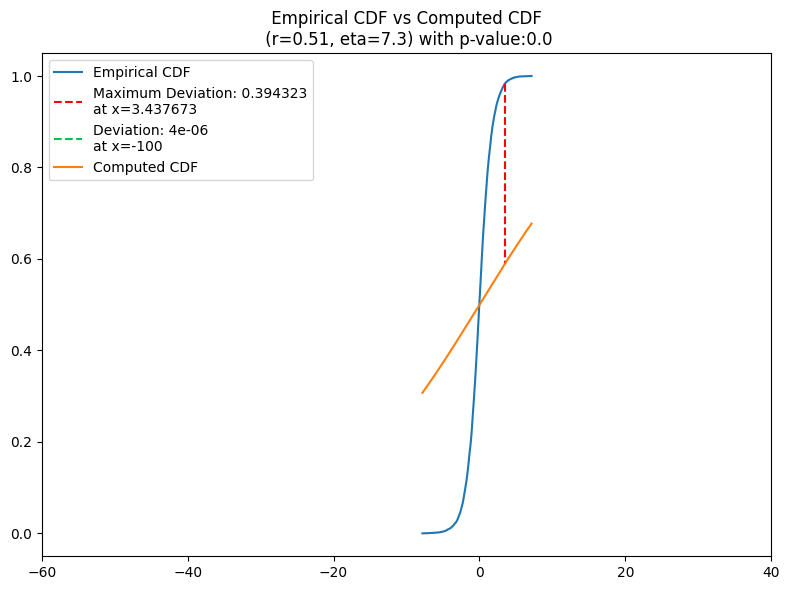

In [15]:
# Example Cell
group = 3
visualize_cdf(sample = sample_prior(1, 1, 10000), 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

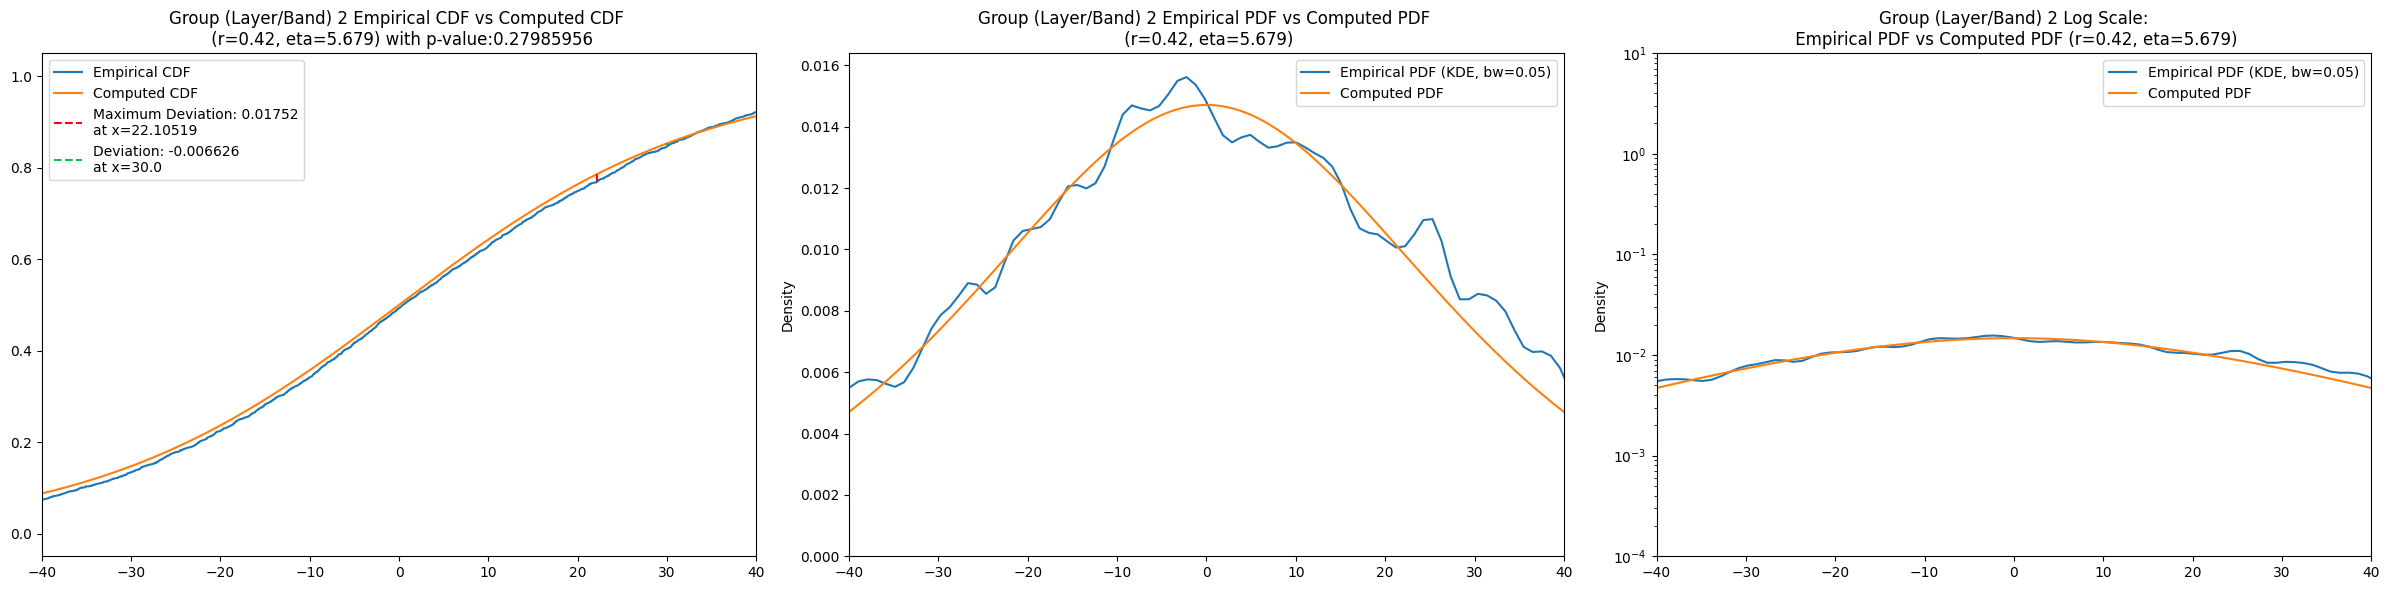

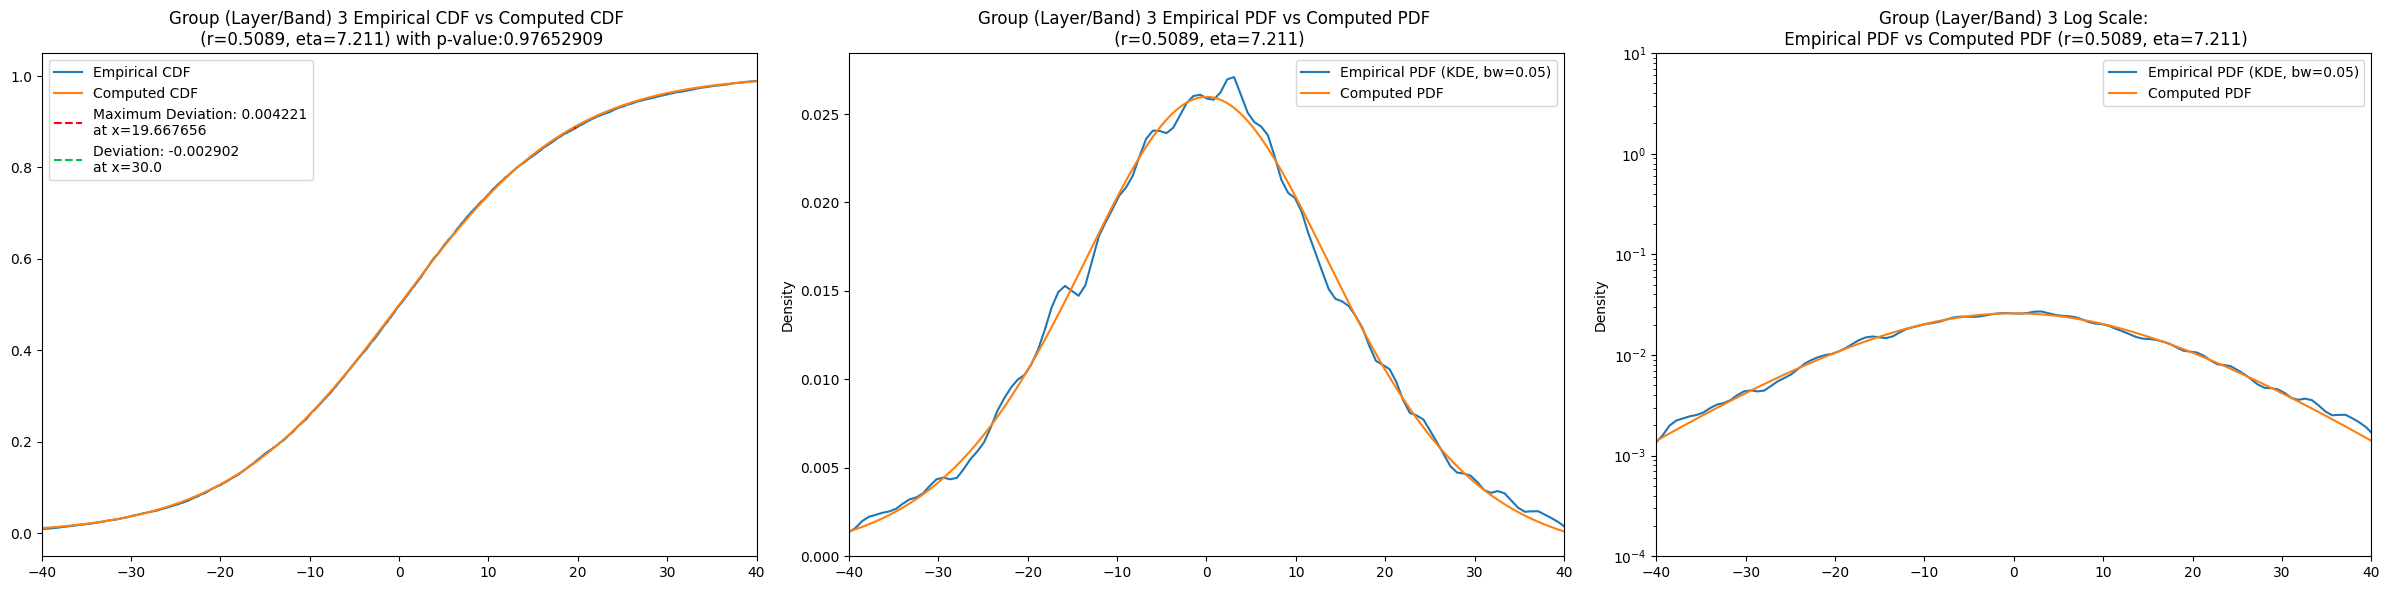

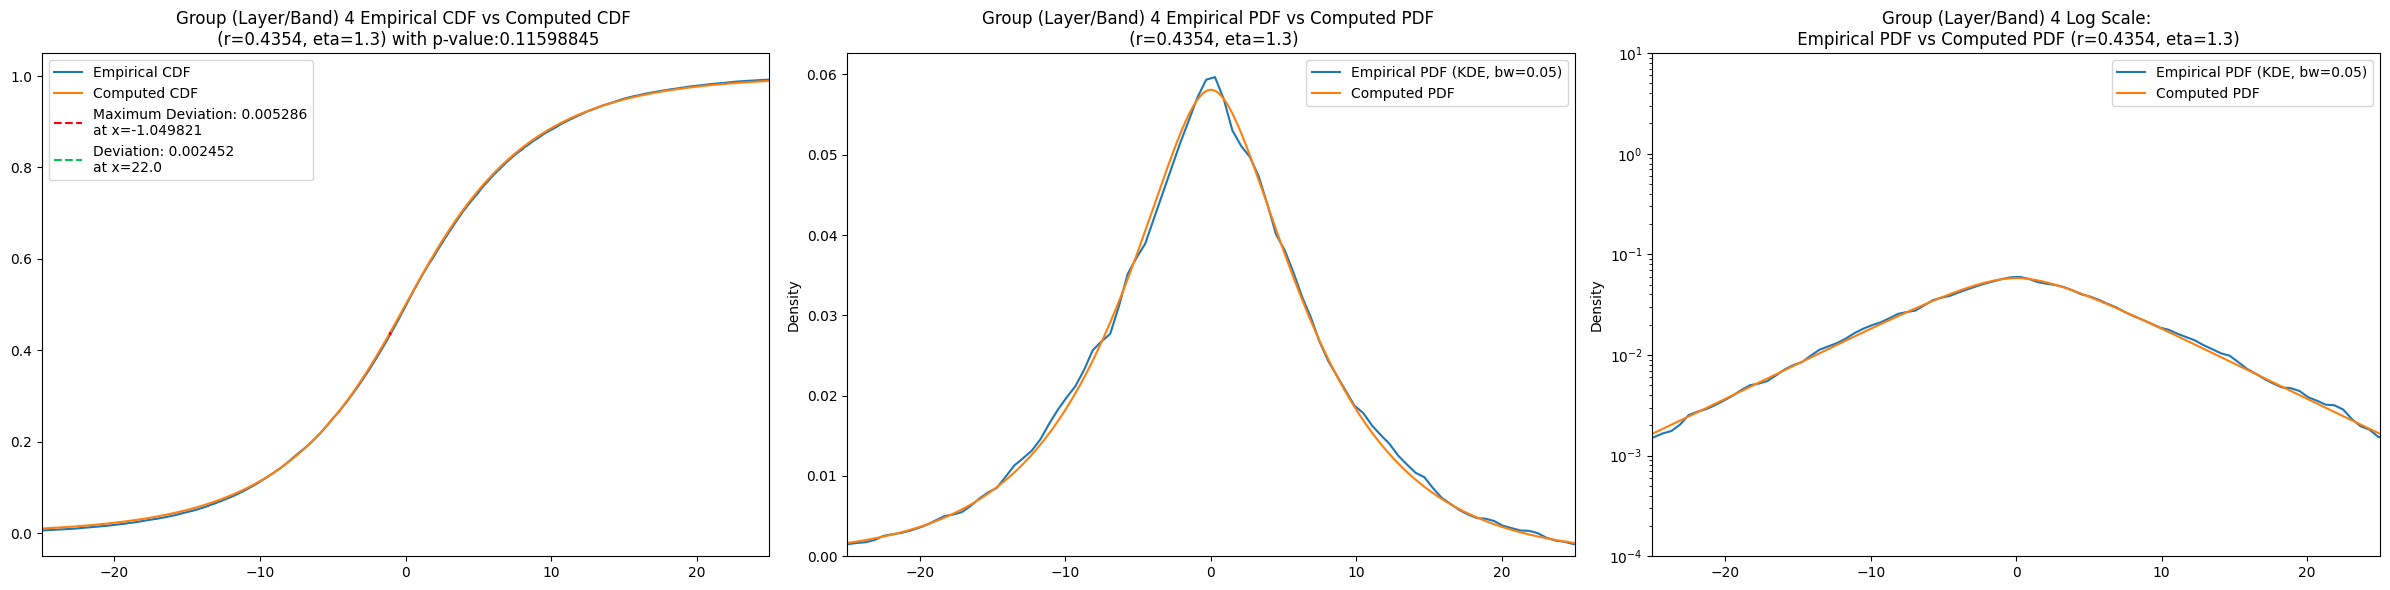

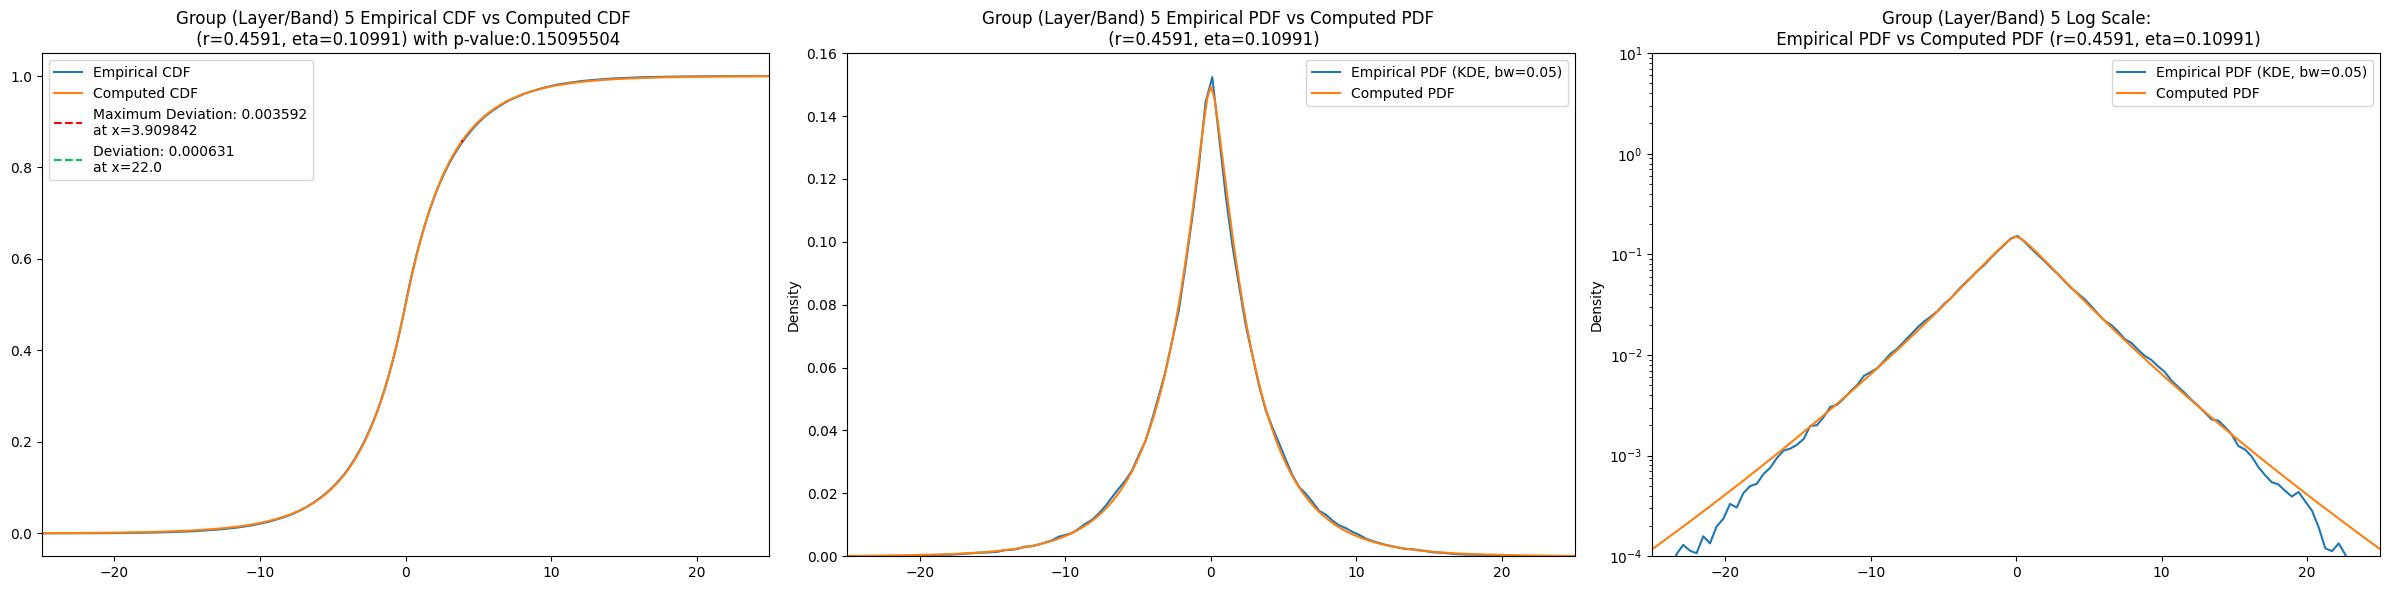

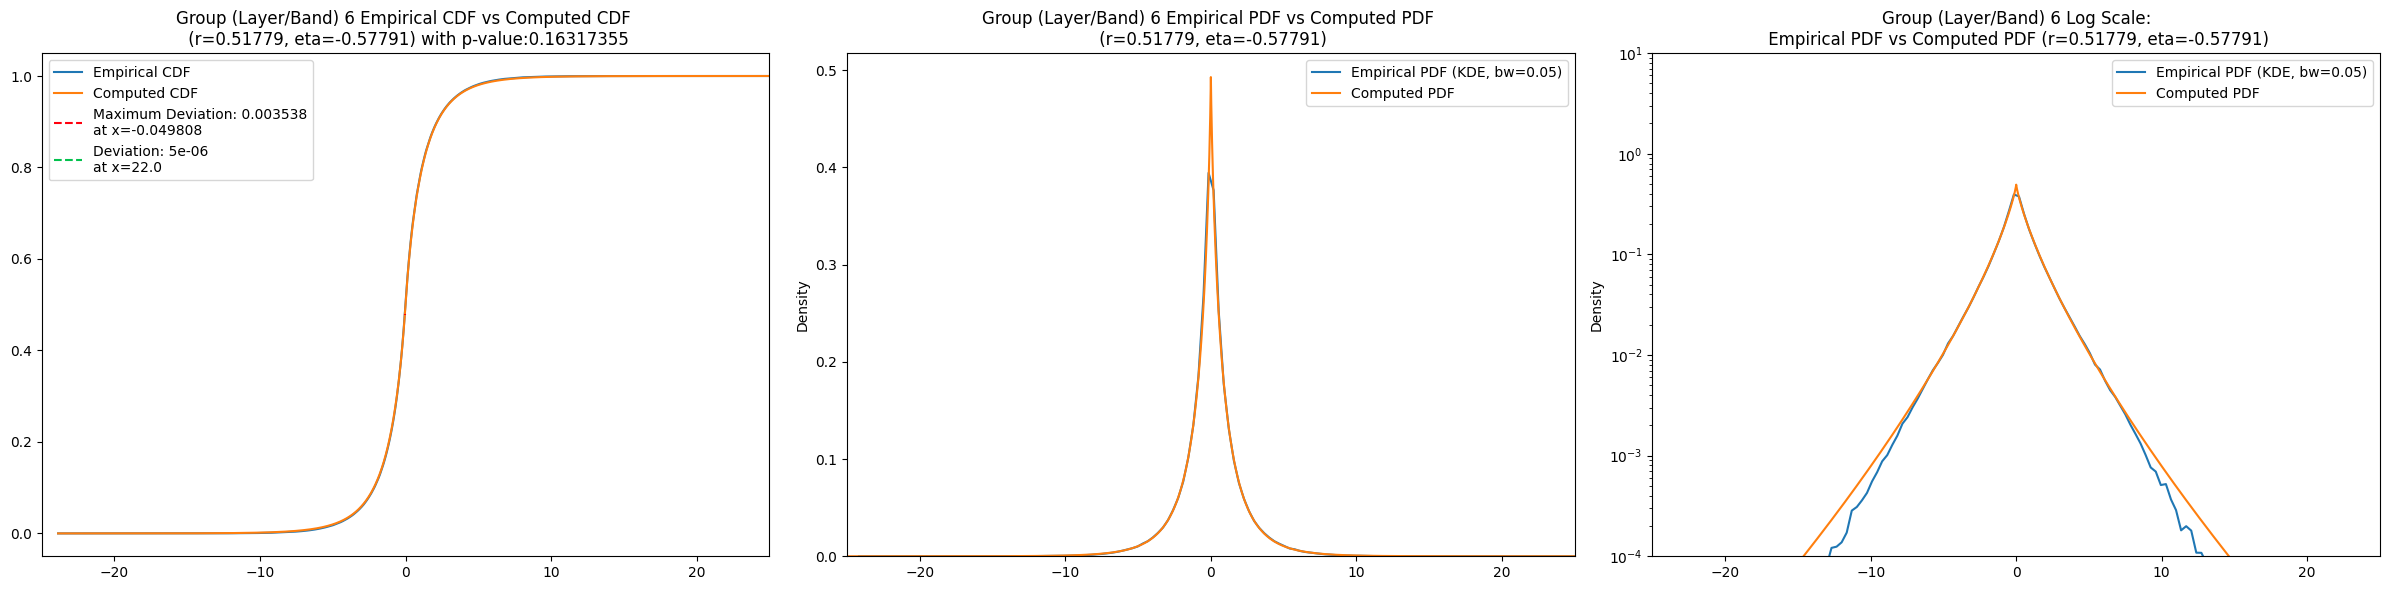

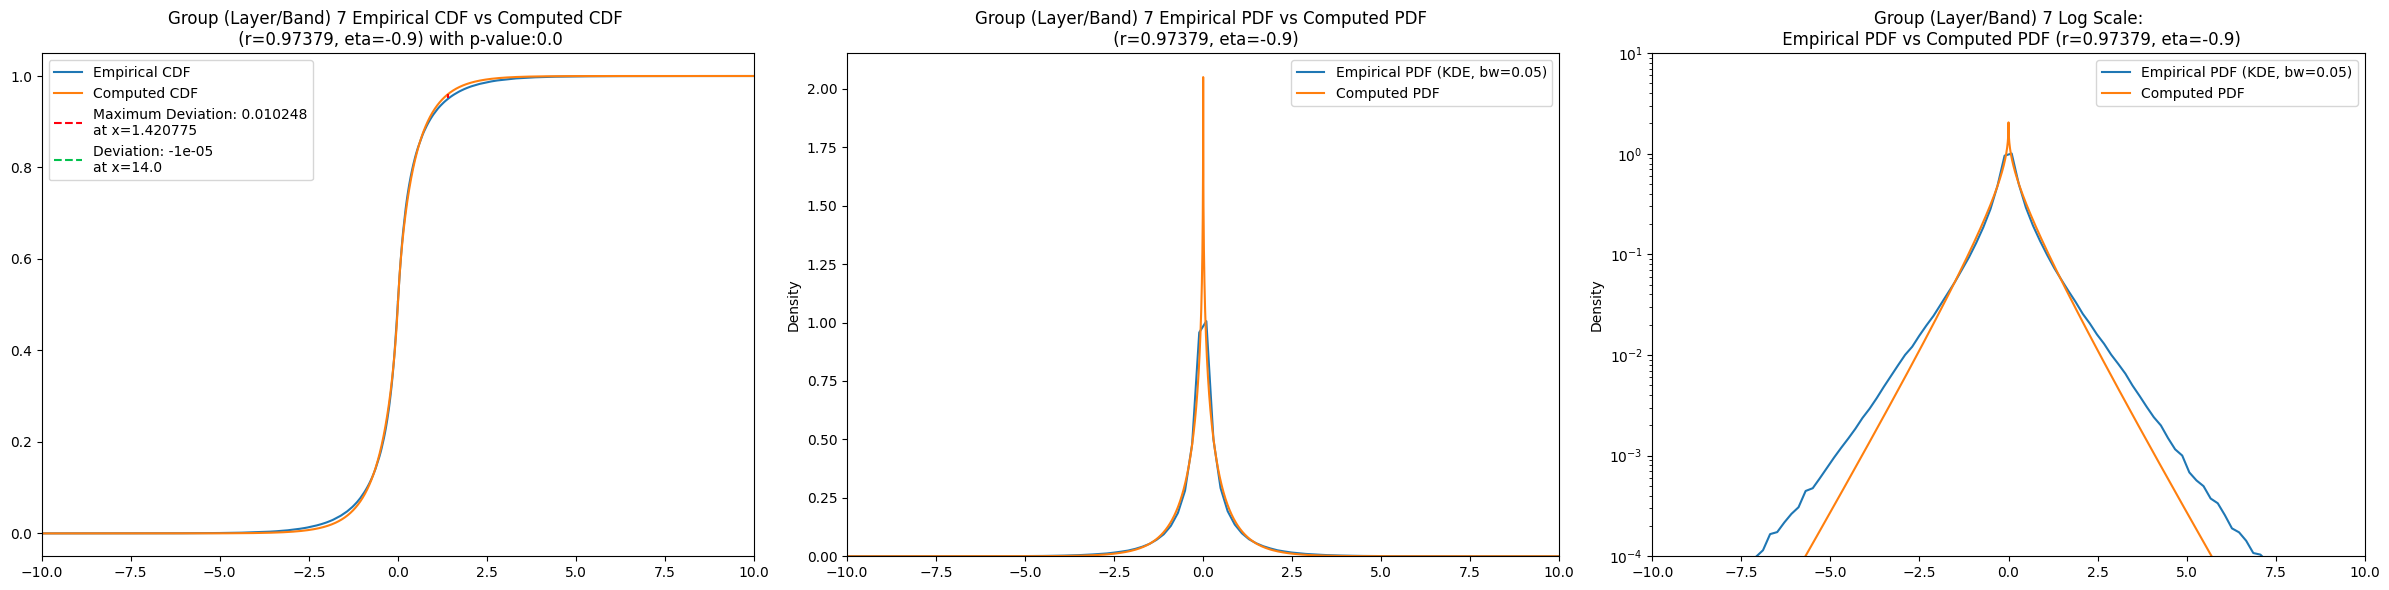

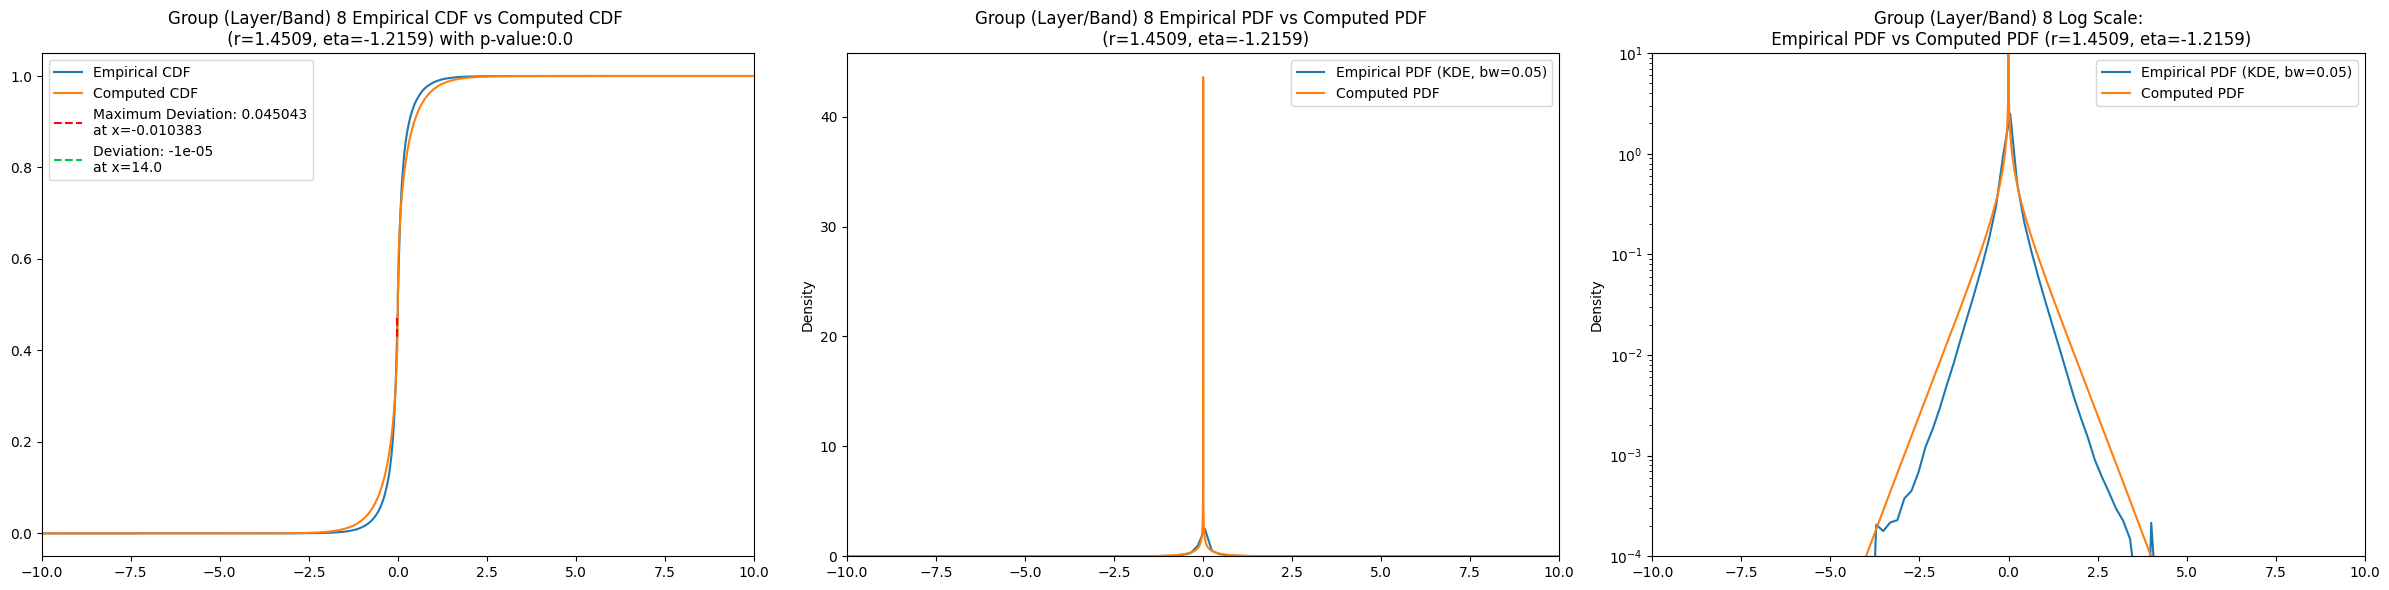

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [18]:
for group in GROUPS:
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var   var_lower   var_upper    obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      803.473892  751.378924  857.028528    0.094996   -0.097312    0.299754   
3      275.270192  264.590167  286.288690    0.374403    0.219221    0.546058   
4       80.847728   77.046186   84.706154    1.357251    1.030759    1.855357   
5       19.882305   18.762781   21.056150    3.074957    2.230657    5.079245   
6        4.187365    3.884993    4.587161    7.592764    3.861297   29.028659   
7        0.819285    0.747353    0.916054   13.123555    6.050411   48.182214   
8        0.136744    0.117431    0.211746  172.661568    8.088640  756.942474   

       total_samples  initial_r  initial_eta  kstest_stat_initial  ...  \
layer                                                              ...   
2             3180.0       0.42          5.7             0.018069  ...   
3            12720.0       0.51          7.3             0.004615  ...   
4            50880.0       0.44          1.4             0.006270  ...   
5           203520.0       0.47          0.2             0.005236  ...   
6           814080.0       0.51         -0.6             0.004349  ...   
7          3256320.0       0.97         -0.9             0.010413  ...   
8         13025280.0       1.44         -1.2             0.051520  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2           27.782300              0.019503          1.755550e-01   
3           16.031400              0.010128          1.460870e-01   
4            8.001070              0.020474          5.852830e-19   
5            3.590200              0.030178         1.856120e-161   
6            1.426190              0.042375          0.000000e+00   
7            0.539656              0.052929          0.000000e+00   
8            0.196027              0.056358          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          25.439100             0.036392         4.282210e-04  20.752800   
3          14.012900             0.022665         4.151010e-06  11.277100   
4           7.104980             0.014498         1.017140e-09   5.719650   
5           3.138870             0.002344         2.129390e-01   2.574090   
6           1.246800             0.014481        1.041130e-148   1.010540   
7           0.472760             0.025282         0.000000e+00   0.378321   
8           0.172569             0.029152         0.000000e+00   0.137349   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.036305   4.458110e-04          2.798600e-01  
3           0.026410   3.854630e-08          9.765300e-01  
4           0.018489   1.538450e-15          1.159900e-01  
5           0.010570   3.529230e-20          1.043800e-02  
6           0.017941  4.909420e-228          2.818200e-09  
7           0.026440   0.000000e+00         1.760700e-297  
8           0.028140   0.000000e+00          0.000000e+00  

[7 rows x 36 columns]

In [20]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios =

obs_var   var_lower   var_upper    obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      803.473892  751.378924  857.028528    0.094996   -0.097312    0.299754   
3      275.270192  264.590167  286.288690    0.374403    0.219221    0.546058   
4       80.847728   77.046186   84.706154    1.357251    1.030759    1.855357   
5       19.882305   18.762781   21.056150    3.074957    2.230657    5.079245   
6        4.187365    3.884993    4.587161    7.592764    3.861297   29.028659   
7        0.819285    0.747353    0.916054   13.123555    6.050411   48.182214   
8        0.136744    0.117431    0.211746  172.661568    8.088640  756.942474   

       total_samples  initial_r  initial_eta  kstest_stat_initial  ...  \
layer                                                              ...   
2             3180.0       0.42          5.7             0.018069  ...   
3            12720.0       0.51          7.3             0.004615  ...   
4            50880.0       0.44          1.4             0.006270  ...   
5           203520.0       0.47          0.2             0.005236  ...   
6           814080.0       0.51         -0.6             0.004349  ...   
7          3256320.0       0.97         -0.9             0.010413  ...   
8         13025280.0       1.44         -1.2             0.051520  ...   

        kstest_ratio_gengamma_tail0  kstest_ratio_gengamma_tail10  \
layer                                                               
2                  (0.1239, 1.0126)              (0.1239, 1.0126)   
3                  (0.25381, 1.016)              (0.25381, 1.016)   
4                (0.098794, 1.0029)            (0.098794, 1.0029)   
5                 (0.28817, 3.9814)             (0.28817, 3.9814)   
6                 (0.37732, 1.0407)             (0.37732, 1.0407)   
7             (0.95921, 15312000.0)         (0.99998, 15312000.0)   
8      (0.32023, 962020000000000.0)      (1.0, 962020000000000.0)   

             kstest_ratio_gaussian_tail0       kstest_ratio_gaussian_tail10  \
layer                                                                         
2                       (0.9368, 1.9545)                   (0.9368, 1.9545)   
3                      (0.96671, 76.943)                  (0.96671, 76.943)   
4                    (0.93633, 391120.0)                (0.97872, 391120.0)   
5      (0.90723, 1.8721999999999998e+35)  (0.98075, 1.8721999999999998e+35)   
6                  (0.87959, 3.0205e+57)              (0.99905, 3.0205e+57)   
7       (0.8501, 6.528000000000002e+269)  (0.99998, 6.528000000000002e+269)   
8                         (0.83653, inf)                         (1.0, inf)   

             kstest_ratio_laplace_tail0        kstest_ratio_laplace_tail10  \
layer                                                                        
2                     (0.95089, 7.3557)                  (0.95089, 7.3557)   
3                     (0.96151, 2839.9)                  (0.96151, 2839.9)   
4                (0.95756, 119260000.0)             (0.95756, 119260000.0)   
5                 (0.95007, 1.8763e+47)              (0.97884, 1.8763e+47)   
6      (0.9364, 2.0407000000000003e+76)  (0.99905, 2.0407000000000003e+76)   
7                        (0.90641, inf)                     (0.99998, inf)   
8                        (0.89532, inf)                         (1.0, inf)   

       kstest_ratio_t_tail0  kstest_ratio_t_tail10  \
layer                                                
2          (0.015521, 1.04)       (0.015521, 1.04)   
3       (0.0074015, 1.1147)    (0.0074015, 1.1147)   
4        (0.003275, 1.0744)     (0.003275, 1.0176)   
5        (0.006972, 1.0662)     (0.006972, 1.0104)   
6        (0.011194, 1.2183)     (0.011194, 1.0041)   
7        (0.037871, 1.5063)     (0.037871, 1.0006)   
8        (0.061503, 1.7144)         (0.37126, 1.0)   

       kstest_stat_gengamma_tail2  kstest_stat_gengamma_tail10  
layer                   

# Results

In [15]:
import pandas as pd
import git
from pathlib import Path
import os
DATA_NAME = 'approx1e5-pastis-wavelet-gray' # size-name-transform-channel
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
CWD


master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)

In [16]:
master_df.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


total_samples  kstest_stat_initial  kstest_stat_cutoff_0.05  \
layer                                                                
2             3180.0             0.018069                 0.024030   
3            12720.0             0.004615                 0.012029   
4            50880.0             0.006270                 0.006018   
5           203520.0             0.005236                 0.003010   
6           814080.0             0.004349                 0.001505   
7          3256320.0             0.010413                 0.000753   
8         13025280.0             0.051520                 0.000376   

       kstest_stat_eta0  kstest_stat_best  kstest_stat_iter1  \
layer                                                          
2              0.060346          0.017520           0.017542   
3              0.037012          0.004221           0.004263   
4              0.023319          0.005286           0.005315   
5              0.005653          0.003592           0.003866   
6              0.020507          0.003538           0.003590   
7              0.082284          0.010248           0.010258   
8              0.227351          0.045043           0.046824   

       kstest_stat_iter2  kstest_stat_iter3  kstest_stat_gaussian  \
layer                                                               
2               0.017520                NaN              0.019503   
3               0.004221                NaN              0.010128   
4               0.005286                NaN              0.020474   
5               0.003596           0.003592              0.030178   
6               0.003542           0.003538              0.042375   
7               0.010249           0.010248              0.052929   
8               0.045086           0.045043              0.056358   

       kstest_stat_laplace  kstest_stat_t  kstest_stat_gengamma_tail2  \
layer                                                                   
2                 0.036392       0.036305                    0.018069   
3                 0.022665       0.026410                    0.004615   
4                 0.014498       0.018489                    0.005812   
5                 0.002344       0.010570                    0.003322   
6                 0.014481       0.017941                    0.002538   
7                 0.025282       0.026440                    0.008446   
8                 0.029152       0.028140                    0.002504   

       kstest_stat_gengamma_tail10  
layer                               
2                         0.018069  
3                         0.003824  
4                         0.005487  
5                         0.001374  
6                         0.000984  
7                         0.000030  
8                         0.000010

In [23]:
# group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))

# for group in GROUPS:
#     cols = ['pass_var', 'pass_kstest', 'pass_kurt']
#     fig = combo_test_plot(group_cdf_df_dict[group], cols, 
#                             plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
#                             target_var = master_df.loc[group, 'obs_var'],
#                             best_param = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']))
#     fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

EOFError: Ran out of input